In [1]:
import pandas as pd

# Load the data from the .csv file
choice_dat = pd.read_csv("/Users/kavyamuraliparthasarathy/Downloads/data/choice_data.csv")

In [2]:
choice_dat['action'] = choice_dat['choice'].apply(lambda x: 0 if x == "Stay in lane" else 1)

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

# Extract relevant features from the dataset
features = ['choice', 'treat.time', 'num.potholes.stay', 'prob.stop.stay', 'num.potholes.change', 'prob.stop.change']

# DataFrame
X = choice_dat[features].values
y = choice_dat['action'].values

# Reshape data for sequence format (assuming a sequence length of 5 )
sequence_length = 5
X_sequences = np.array([X[i:i+sequence_length] for i in range(X.shape[0] - sequence_length)])
y_sequences = y[sequence_length:]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42)


In [4]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(None, X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [5]:
non_numeric_entries = []

# Iterate through the elements of X_train
for row in X_train:
    for sublist in row:
        for item in sublist:
            if not isinstance(item, (int, float)):
                non_numeric_entries.append(item)

# Convert to a set to get unique non-numeric entries
unique_non_numeric = set(non_numeric_entries)

print("Unique non-numeric values in X_train:", unique_non_numeric)

Unique non-numeric values in X_train: {'Change lane', '5 seconds limit', '30 seconds limit', 'No time limit', '20 seconds limit', '25 seconds limit', '10 seconds limit', '60 seconds limit', '15 seconds limit', 'Stay in lane', 'No choice made'}


In [7]:
 #Reshape X_train to combine the first two dimensions
X_train_2d = X_train.reshape(-1, X_train.shape[-1])

# Convert the reshaped X_train to a DataFrame
df_X_train_2d = pd.DataFrame(X_train_2d)

# One-hot encode the categorical columns
df_encoded_2d = pd.get_dummies(df_X_train_2d)

# Convert back to an array
X_train_encoded_2d = df_encoded_2d.values

# Reshape the data to its original three-dimensional form
X_train_encoded = X_train_encoded_2d.reshape(X_train.shape[0], X_train.shape[1], -1)


In [8]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(None, X_train_encoded.shape[2])))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model

model.fit(X_train_encoded, y_train, epochs=20, validation_split=0.2, verbose=1)


Epoch 1/20
1028/1028 [==============================] - 2s 1ms/step - loss: 0.2229 - accuracy: 0.9415 - val_loss: 0.1813 - val_accuracy: 0.9553
Epoch 2/20
1028/1028 [==============================] - 1s 1ms/step - loss: 0.1741 - accuracy: 0.9579 - val_loss: 0.1777 - val_accuracy: 0.9551
Epoch 3/20
1028/1028 [==============================] - 1s 1ms/step - loss: 0.1712 - accuracy: 0.9579 - val_loss: 0.1781 - val_accuracy: 0.9554
Epoch 4/20
1028/1028 [==============================] - 1s 1ms/step - loss: 0.1701 - accuracy: 0.9581 - val_loss: 0.1784 - val_accuracy: 0.9555
Epoch 5/20
1028/1028 [==============================] - 1s 1ms/step - loss: 0.1692 - accuracy: 0.9581 - val_loss: 0.1766 - val_accuracy: 0.9555
Epoch 6/20
1028/1028 [==============================] - 1s 1ms/step - loss: 0.1683 - accuracy: 0.9581 - val_loss: 0.1797 - val_accuracy: 0.9555
Epoch 7/20
1028/1028 [==============================] - 1s 1ms/step - loss: 0.1675 - accuracy: 0.9581 - val_loss: 0.1775 - val_accuracy:

In [9]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

In [10]:
# Reshaping X_test to combine the first two dimensions for encoding
X_test_2d = X_test.reshape(-1, X_test.shape[-1])

In [11]:
# Converting the reshaped X_test to a DataFrame
df_X_test_2d = pd.DataFrame(X_test_2d)

In [12]:
df_encoded_test_2d = pd.get_dummies(df_X_test_2d)
df_encoded_test_2d = df_encoded_test_2d.reindex(columns=df_encoded_2d.columns, fill_value=0)

In [13]:
# Reshaping the data to its original three-dimensional form

X_test_encoded = df_encoded_test_2d.values.reshape(X_test.shape[0], X_test.shape[1], -1)

In [14]:
# Evaluating the model
loss, accuracy = model.evaluate(X_test_encoded, y_test, verbose=1)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


322/322 [==============================] - 0s 421us/step - loss: 0.1618 - accuracy: 0.9582
Test Loss: 0.16180261969566345
Test Accuracy: 0.9581671357154846


In [15]:
# Make predictions
predictions = model.predict(X_test_encoded, verbose=1)

# If it's a binary classification, convert probabilities to class labels

predictions = np.round(predictions).astype(int)

#view the first few predictions
print(predictions[:5])


322/322 [==============================] - 0s 397us/step
[[0]
 [1]
 [0]
 [1]
 [1]]


In [16]:
from sklearn.metrics import confusion_matrix, classification_report

conf_matrix = confusion_matrix(y_test, predictions)
class_report = classification_report(y_test, predictions)

print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[4858  228]
 [ 202 4991]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      5086
           1       0.96      0.96      0.96      5193

    accuracy                           0.96     10279
   macro avg       0.96      0.96      0.96     10279
weighted avg       0.96      0.96      0.96     10279



In [17]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming y_test and predictions are available in your current environment

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver Operating Characteristic', fontsize=18)
plt.legend(loc="lower right", fontsize=14)
plt.grid(True)

plt.savefig('/Users/kavyamuraliparthasarathy/Desktop/Plots/roc_curve.png')  


plt.close()  
plt.show()  

In [18]:
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from sklearn.metrics import accuracy_score

# Define a function to create the model with different activation functions
def create_model(activation_function):
    model = Sequential()
    
    model.add(LSTM(50, activation=activation_function, input_shape=(None, X_train_encoded.shape[2])))
    
    
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [19]:
# Activation functions to compare
activations = ['relu', 'sigmoid', 'tanh']

# Dictionary to store models
models = {}

# Dictionary to store training histories
histories = {}

In [20]:
# Train a model for each activation function
for activation in activations:
    print(f"Training model with {activation} activation...")
    model = create_model(activation)
    history = model.fit(X_train_encoded, y_train, epochs=20, validation_split=0.2, verbose=1)
    
    # Save the model and history
    models[activation] = model
    histories[activation] = history

    # Evaluate on the test set
    scores = model.evaluate(X_test_encoded, y_test, verbose=0)
    print(f"{activation} Activation - Test Loss: {scores[0]} - Test Accuracy: {scores[1]}")

Training model with relu activation...
Epoch 1/20
1028/1028 [==============================] - 2s 1ms/step - loss: 0.2248 - accuracy: 0.9393 - val_loss: 0.1851 - val_accuracy: 0.9553
Epoch 2/20
1028/1028 [==============================] - 1s 1ms/step - loss: 0.1741 - accuracy: 0.9579 - val_loss: 0.1799 - val_accuracy: 0.9551
Epoch 3/20
1028/1028 [==============================] - 1s 1ms/step - loss: 0.1711 - accuracy: 0.9580 - val_loss: 0.1783 - val_accuracy: 0.9555
Epoch 4/20
1028/1028 [==============================] - 1s 1ms/step - loss: 0.1694 - accuracy: 0.9581 - val_loss: 0.1769 - val_accuracy: 0.9555
Epoch 5/20
1028/1028 [==============================] - 1s 1ms/step - loss: 0.1687 - accuracy: 0.9582 - val_loss: 0.1768 - val_accuracy: 0.9555
Epoch 6/20
1028/1028 [==============================] - 1s 1ms/step - loss: 0.1683 - accuracy: 0.9581 - val_loss: 0.1764 - val_accuracy: 0.9555
Epoch 7/20
1028/1028 [==============================] - 1s 1ms/step - loss: 0.1677 - accuracy: 0.

1028/1028 [==============================] - 1s 1ms/step - loss: 0.1625 - accuracy: 0.9581 - val_loss: 0.1718 - val_accuracy: 0.9555
Epoch 16/20
1028/1028 [==============================] - 1s 1ms/step - loss: 0.1621 - accuracy: 0.9581 - val_loss: 0.1738 - val_accuracy: 0.9555
Epoch 17/20
1028/1028 [==============================] - 1s 1ms/step - loss: 0.1616 - accuracy: 0.9581 - val_loss: 0.1713 - val_accuracy: 0.9555
Epoch 18/20
1028/1028 [==============================] - 1s 1ms/step - loss: 0.1610 - accuracy: 0.9581 - val_loss: 0.1702 - val_accuracy: 0.9555
Epoch 19/20
1028/1028 [==============================] - 1s 1ms/step - loss: 0.1607 - accuracy: 0.9581 - val_loss: 0.1704 - val_accuracy: 0.9555
Epoch 20/20
1028/1028 [==============================] - 1s 1ms/step - loss: 0.1602 - accuracy: 0.9581 - val_loss: 0.1720 - val_accuracy: 0.9555
tanh Activation - Test Loss: 0.16597014665603638 - Test Accuracy: 0.9581671357154846


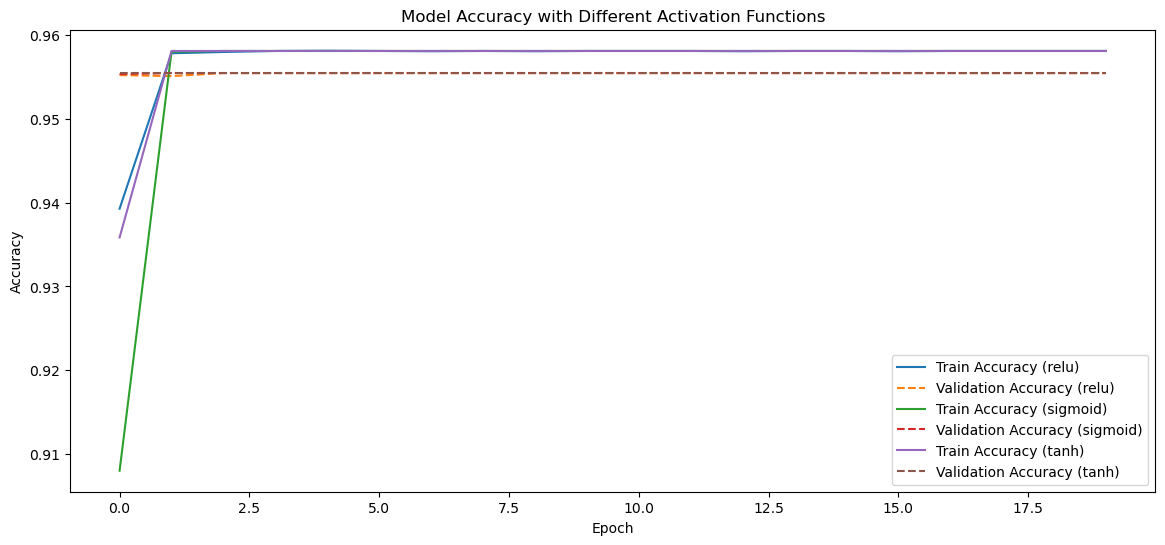

In [21]:

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Summarize history for accuracy
for activation in activations:
    plt.plot(histories[activation].history['accuracy'], label=f'Train Accuracy ({activation})')
    plt.plot(histories[activation].history['val_accuracy'], label=f'Validation Accuracy ({activation})', linestyle='--')

plt.title('Model Accuracy with Different Activation Functions')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()


plt.figure(figsize=(14, 6))

for activation in activations:
    plt.plot(histories[activation].history['loss'], label=f'Train Loss ({activation})')
    plt.plot(histories[activation].history['val_loss'], label=f'Validation Loss ({activation})', linestyle='--')

plt.title('Model Loss with Different Activation Functions')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.savefig('/Users/kavyamuraliparthasarathy/Desktop/Plots/model_accuracy.png')  
# Save the figure as a PNG


plt.close()  #
plt.show()  
